# **Parseval Network**

# **Data Preparation**

In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [2]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, Y_data, test_size=0.33, random_state=42)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe

y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])
y_test_df = pd.DataFrame(y_test, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_test_df['New'] = labelencoder.fit_transform(y_test_df['Label'])

In [6]:
from keras import backend as K
img_rows, img_cols = X_train[0].shape


# transform data set
if K.common.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Using TensorFlow backend.


**Parseval Network**

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='Orthogonal', kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_parseval_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    init = (68, 100,1)

    parseval_16_2 = create_parseval_network(init, nb_classes=4, N=2, k=2, dropout=0.3)


conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.callbacks as callbacks


In [0]:
EPOCHS = 200
BS = 128
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.1, momentum=0.9)

In [12]:
parseval_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
import tensorflow
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
def lr_sch(epoch):
    if epoch < 60:
        return 0.1
    elif epoch < 120:
        return 0.02
    elif epoch < 160:
        return 0.004
    else:
        return 0.0008

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [15]:
from tensorflow.keras.utils import to_categorical
hist = parseval_16_2.fit(generator.flow(X_train, to_categorical(y_train_df['New']), batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   validation_data=(X_test, to_categorical(y_test_df['New'])), callbacks = [lr_scheduler],
                   validation_steps=X_test.shape[0] // BS,)

Epoch 1/200
29/29 [==============================] - 19s 662ms/step - loss: 1.8353 - acc: 0.3398 - val_loss: 2.5095 - val_acc: 0.3049 - lr: 0.1000
Epoch 2/200
29/29 [==============================] - 16s 541ms/step - loss: 1.7557 - acc: 0.3795 - val_loss: 1.6968 - val_acc: 0.4373 - lr: 0.1000
Epoch 3/200
29/29 [==============================] - 16s 546ms/step - loss: 1.7062 - acc: 0.3952 - val_loss: 1.6292 - val_acc: 0.4357 - lr: 0.1000
Epoch 4/200
29/29 [==============================] - 16s 544ms/step - loss: 1.6401 - acc: 0.4197 - val_loss: 1.5726 - val_acc: 0.4960 - lr: 0.1000
Epoch 5/200
29/29 [==============================] - 16s 544ms/step - loss: 1.5475 - acc: 0.4964 - val_loss: 1.5092 - val_acc: 0.5161 - lr: 0.1000
Epoch 6/200
29/29 [==============================] - 16s 543ms/step - loss: 1.4863 - acc: 0.5247 - val_loss: 1.5476 - val_acc: 0.4542 - lr: 0.1000
Epoch 7/200
29/29 [==============================] - 16s 543ms/step - loss: 1.4464 - acc: 0.5406 - val_loss: 1.7007 - 

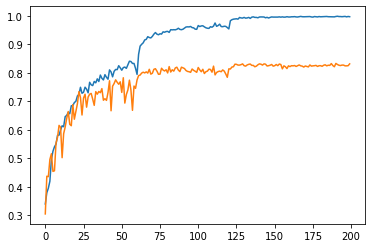

In [16]:
from matplotlib import  pyplot

pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')


In [0]:
test_err = [1.0-x for x in hist.history['val_acc']]

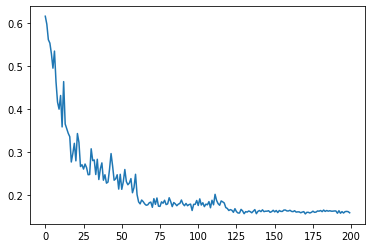

In [0]:
pyplot.plot(test_err, label='test')
pyplot.savefig("deneme_err.png")

In [0]:
import tensorflow as tf
parseval_16_2.save("parseval_tensor_lst.h5")

In [0]:
y_pred = parseval_16_2.predict(X_test)

In [0]:
parseval_16_2.evaluate(X_test,to_categorical(y_test_df['New']),batch_size=128,verbose=2)

15/15 - 2s - loss: 0.9231 - acc: 0.8412


[0.9231326580047607, 0.8411858081817627]

In [0]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 501kB 39.0MB/s 
     |████████████████████████████████| 3.1MB 44.9MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-wgp3ajip/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-wgp3ajip/cleverhans
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262572 sha256=9b140e898b4fd588b7d61044063a489b678633c8bb1e1e90c30e9ec89fb65772
  Stored in directory: /tmp/pip-ephem-wheel-cache-g87wshp1/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans

Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [0]:
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(wrn_28_10.input,wrn_28_10.layers[-1].output)

In [0]:
random_index = 5

original_image = X_test[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,68,100))) 

In [0]:
original_image.shape

TensorShape([1, 68, 100])

In [0]:
wrn_28_10(original_image)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.1158982e-08, 8.5471781e-09, 9.9708480e-01, 2.9151759e-03]],
      dtype=float32)>

In [0]:
y_test_cat = to_categorical(y_test_df['New'])

In [0]:
original_label = y_test_cat[random_index]
original_label 

array([0., 0., 1., 0.], dtype=float32)

In [0]:
epsilon = 0.33


adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = wrn_28_10.predict(adv_example_untargeted_label)

In [0]:
adv_example_untargeted_label

<tf.Tensor: shape=(1, 68, 100), dtype=float32, numpy=
array([[[-0.2543156 , -0.71246445, -0.86518073, ...,  0.5092658 ,
          1.3983403 ,  2.0855637 ],
        [-0.02524117, -0.05246446,  0.10025184, ...,  1.0437728 ,
          0.43290767,  0.81469834],
        [ 1.2456241 ,  0.48204255,  0.48204255, ...,  0.5092658 ,
          0.81469834,  1.0437728 ],
        ...,
        [ 1.5510566 ,  1.4746984 ,  1.0929077 , ...,  0.10025184,
          0.05111697, -0.17795746],
        [ 1.5510566 ,  1.1692659 ,  1.7037729 , ..., -0.02524117,
         -0.33067375, -0.33067375],
        [ 0.585624  ,  0.585624  ,  1.2456241 , ...,  0.20383325,
          0.9401914 ,  0.5584007 ]]], dtype=float32)>

In [0]:
np.argmax(adv_example_untargeted_label_pred)

3

In [0]:
original_image = tf.reshape(adv_example_untargeted_label, (68,100))

In [0]:
original_image

<tf.Tensor: shape=(68, 100), dtype=float32, numpy=
array([[-0.2543156 , -0.71246445, -0.86518073, ...,  0.5092658 ,
         1.3983403 ,  2.0855637 ],
       [-0.02524117, -0.05246446,  0.10025184, ...,  1.0437728 ,
         0.43290767,  0.81469834],
       [ 1.2456241 ,  0.48204255,  0.48204255, ...,  0.5092658 ,
         0.81469834,  1.0437728 ],
       ...,
       [ 1.5510566 ,  1.4746984 ,  1.0929077 , ...,  0.10025184,
         0.05111697, -0.17795746],
       [ 1.5510566 ,  1.1692659 ,  1.7037729 , ..., -0.02524117,
        -0.33067375, -0.33067375],
       [ 0.585624  ,  0.585624  ,  1.2456241 , ...,  0.20383325,
         0.9401914 ,  0.5584007 ]], dtype=float32)>

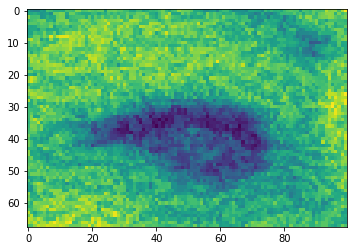

In [0]:
import matplotlib.pyplot as plt
import numpy as np
X = np.random.random((100, 100)) # sample 2D array
plt.imshow(original_image)
plt.show()

In [0]:
y_test_cat[random_index]

array([0., 0., 1., 0.], dtype=float32)

In [0]:
y_test[random_index]

'open'